# 東京エレクトロン株価（日足）値幅

In [18]:
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import yfinance as yf

#symbol = '6146.T'
#symbol = '6920.T'
#symbol = '7735.T'
symbol = '8035.T'
ticker = yf.Ticker(symbol)

#df = ticker.history(period='5d', interval='15m')
df = ticker.history(period='3mo')
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-08-14 00:00:00+09:00,27612.983794,27702.057935,26341.202999,26944.927734,7507300,0.0,0.0
2024-08-15 00:00:00+09:00,26781.626113,27603.087668,26732.140477,27335.865234,5210900,0.0,0.0
2024-08-16 00:00:00+09:00,28325.577109,28889.713341,28117.737445,28657.130859,6459500,0.0,0.0
2024-08-19 00:00:00+09:00,28483.932354,28835.280373,27593.190897,27766.390625,5805700,0.0,0.0
2024-08-20 00:00:00+09:00,28350.320109,28459.188505,27909.897960,28112.789062,4225600,0.0,0.0
...,...,...,...,...,...,...,...
2024-11-08 00:00:00+09:00,23595.000000,23680.000000,23100.000000,23250.000000,3183100,0.0,0.0
2024-11-11 00:00:00+09:00,22990.000000,23315.000000,22880.000000,23260.000000,2325300,0.0,0.0
2024-11-12 00:00:00+09:00,23220.000000,23245.000000,22385.000000,22605.000000,3612000,0.0,0.0


## パラボリック SAR

In [19]:
def psar(ohlc: pd.DataFrame, iaf: float = 0.02, maxaf: float = 0.2) -> dict:
    length = len(ohlc)
    high = ohlc['High'].tolist()
    low = ohlc['Low'].tolist()
    close = ohlc['Close'].tolist()
 
    psar = close[0:len(close)]
    psarbull = [None] * length
    psarbear = [None] * length
 
    bull = True
    af = iaf
    ep = low[0]
    price_high = high[0]
    price_low = low[0]
 
    for i in range(2, length):
        if bull:
            psar[i] = psar[i - 1] + af * (price_high - psar[i - 1])
        else:
            psar[i] = psar[i - 1] + af * (price_low - psar[i - 1])
        reverse = False
 
        if bull:
            if low[i] < psar[i]:
                bull = False
                reverse = True
                psar[i] = price_high
                price_low = low[i]
                af = iaf
        else:
            if high[i] > psar[i]:
                bull = True
                reverse = True
                psar[i] = price_low
                price_high = high[i]
                af = iaf
 
        if not reverse:
            if bull:
                if high[i] > price_high:
                    price_high = high[i]
                    af = min(af + iaf, maxaf)
                if low[i - 1] < psar[i]:
                    psar[i] = low[i - 1]
                if low[i - 2] < psar[i]:
                    psar[i] = low[i - 2]
            else:
                if low[i] < price_low:
                    price_low = low[i]
                    af = min(af + iaf, maxaf)
                if high[i - 1] > psar[i]:
                    psar[i] = high[i - 1]
                if high[i - 2] > psar[i]:
                    psar[i] = high[i - 2]
 
        if bull:
            psarbull[i] = psar[i]
        else:
            psarbear[i] = psar[i]
 
    return {
        'bear': np.array(psarbear, dtype='float64'),
        'bull': np.array(psarbull, dtype='float64'),
    }

## 日足チャートとパラボリック SAR

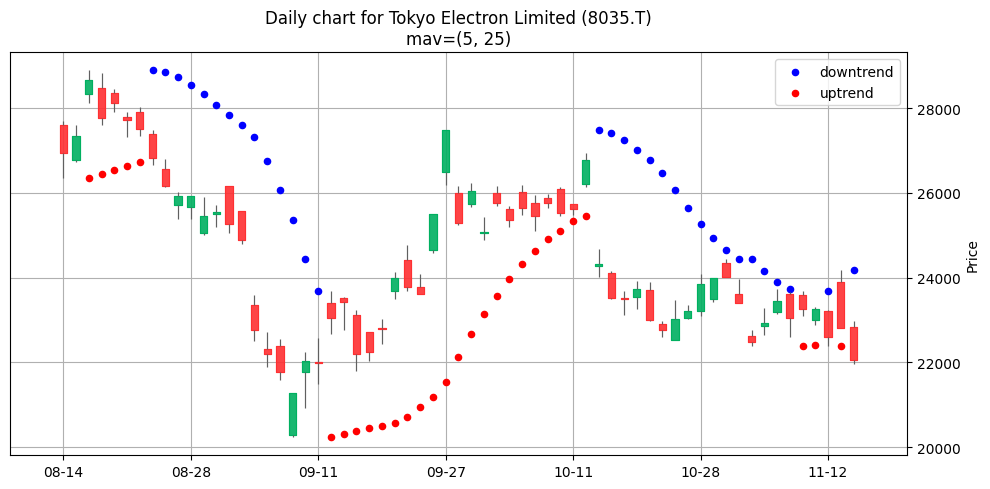

In [20]:
dict_psar = psar(df)

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)

apds  = [
    mpf.make_addplot(
        dict_psar['bear'],
        type='scatter',
        marker='o',
        markersize=20,
        color='blue',
        label='downtrend',
        ax=ax
    ),
    mpf.make_addplot(
        dict_psar['bull'],
        type='scatter',
        marker='o',
        markersize=20,
        color='red',
        label='uptrend',
        ax=ax
    ),
] 

mpf.plot(
    df,
    type='candle',
    style='yahoo',
    volume=False,
    datetime_format='%m-%d',
    addplot=apds,
    xrotation=0,
    ax=ax,
)
try:
    ax.set_title('Daily chart for %s (%s)\nmav=(5, 25)' % (ticker.info['longName'], symbol))
except KeyError:
    ax.set_title('Daily chart for %s\nmav=(5, 25)' % symbol)

ax.grid()

plt.tight_layout()
plt.savefig('daily_chart_8035.png')
plt.show()

In [21]:
df.tail(2)['Close']

Date
2024-11-13 00:00:00+09:00    22805.0
2024-11-14 00:00:00+09:00    22045.0
Name: Close, dtype: float64

In [22]:
df.tail(2)['Close'].diff()

Date
2024-11-13 00:00:00+09:00      NaN
2024-11-14 00:00:00+09:00   -760.0
Name: Close, dtype: float64

In [23]:
ser_delta = df['High'] - df['Low']

In [24]:
ser_ewm = ser_delta.ewm(span=5).mean()
ser_ewm

Date
2024-08-14 00:00:00+09:00    1360.854936
2024-08-15 00:00:00+09:00    1066.910289
2024-08-16 00:00:00+09:00     927.204524
2024-08-19 00:00:00+09:00    1058.002888
2024-08-20 00:00:00+09:00     862.715212
                                ...     
2024-11-08 00:00:00+09:00     686.874313
2024-11-11 00:00:00+09:00     602.916209
2024-11-12 00:00:00+09:00     688.610806
2024-11-13 00:00:00+09:00     922.407204
2024-11-14 00:00:00+09:00     953.271469
Length: 63, dtype: float64

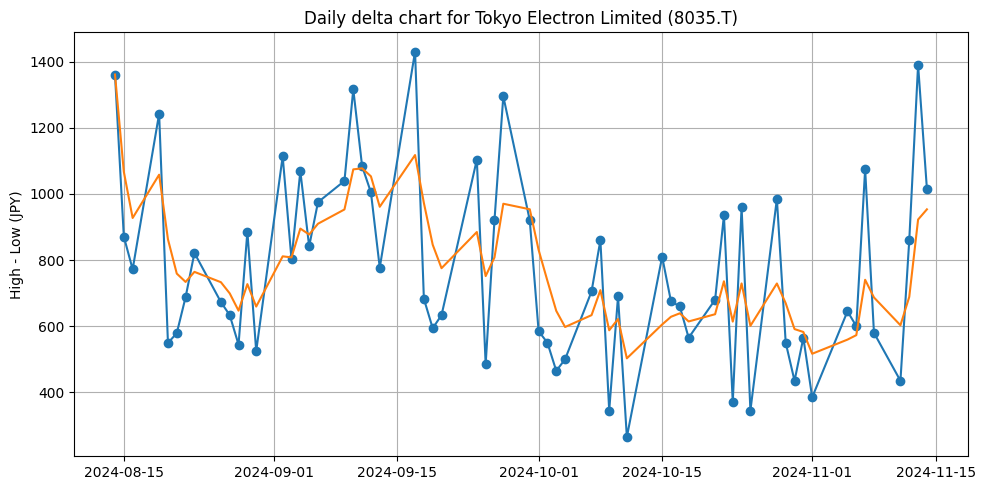

In [25]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)

ax.plot(ser_delta, marker='o')
ax.plot(ser_ewm)

ax.set_ylabel('High - Low (JPY)')

try:
    ax.set_title('Daily delta chart for %s (%s)' % (ticker.info['longName'], symbol))
except KeyError:
    ax.set_title('Daily delta chart for %s' % symbol)
ax.grid()

plt.tight_layout()
plt.savefig('daily_chart_delta_8035.png')
plt.show()

In [9]:
ser_delta.median()

np.float64(690.0)

In [17]:
l = len(ser_delta)
p = 10
ser_delta[l - p - 1:l-1].mean()

np.float64(697.0)